
# Step 2 — Acoustic Feature Extraction (16‑D per Utterance)

This notebook computes a compact **prosodic + spectral** feature vector for each processed audio file:

- **MFCCs (13):** mean across time of coefficients **0–12** (0th ≈ log‑energy)
- **Pitch (F0):** mean over voiced frames (unvoiced → ignored; all‑unvoiced → 0)
- **Energy (RMS):** mean RMS
- **Spectral Centroid:** mean centroid (Hz)

**Framing:** 25 ms window, 10 ms hop, **Hamming** window; `n_fft=512`, `n_mels=40`.  
**Input:** WAVs at **16 kHz** from `data/processed/<emotion>/[Actor_XX]/...`.  
**Output:**  
- `data/processed/features_16d.csv`  
- `data/processed/features_16d_scaled.csv` (z‑scored)  
- `data/processed/scaler_standard.pkl` (for reuse)


## Install (run if needed)

In [2]:

# %pip install librosa soundfile numpy pandas tqdm scikit-learn joblib matplotlib scipy


## Config (paths + analysis params)

In [3]:

from pathlib import Path

# 📁 Place this notebook in thesis_code/notebooks/
# Default data root (sibling of notebooks/)
BASE_DATA = Path("/Users/nishchalpokhrel/Documents/project/thesis_code/data")

# If you run this from somewhere else, set an absolute path instead:
# BASE_DATA = Path("/Users/nishchalpokhrel/Documents/project/thesis_code/data")

PROCESSED_DIR       = BASE_DATA / "processed"
FEATURES_CSV        = PROCESSED_DIR / "features_16d.csv"
FEATURES_SCALED_CSV = PROCESSED_DIR / "features_16d_scaled.csv"
SCALER_PATH         = PROCESSED_DIR / "scaler_standard.pkl"

# Analysis parameters (16 kHz audio from Step 1)
SR = 16000
FRAME_LEN_MS = 25
HOP_MS       = 10

win_length = int(SR * FRAME_LEN_MS / 1000.0)  # 400
hop_length = int(SR * HOP_MS / 1000.0)        # 160
n_fft = 512
n_mfcc = 13
n_mels = 40

# Pitch range for speech (Hz)
F0_MIN_HZ = 50.0
F0_MAX_HZ = 500.0

print("BASE_DATA     =", BASE_DATA.resolve())
print("PROCESSED_DIR =", PROCESSED_DIR.resolve())
print("win/hop (samples) =", win_length, hop_length)


BASE_DATA     = /Users/nishchalpokhrel/Documents/project/thesis_code/data
PROCESSED_DIR = /Users/nishchalpokhrel/Documents/project/thesis_code/data/processed
win/hop (samples) = 400 160


## Imports & helpers

In [4]:

import math
import numpy as np
import pandas as pd
from tqdm import tqdm
import librosa, soundfile as sf
from scipy.signal import resample_poly  # robust resampling (no resampy dependency)
from sklearn.preprocessing import StandardScaler
import joblib

def safe_load_mono(path: Path, sr_expected: int):
    """Read WAV → mono float32; resample to sr_expected if needed with polyphase."""
    y, sr = sf.read(str(path), always_2d=False)
    if y.ndim > 1:
        y = y.mean(axis=1)
    y = y.astype(np.float32, copy=False)
    if sr != sr_expected:
        g = math.gcd(sr, sr_expected)
        up, down = sr_expected // g, sr // g
        y = resample_poly(y, up, down)
        sr = sr_expected
    return y, sr

def mean_ignore_nan(x, fallback=0.0):
    x = np.asarray(x)
    if x.size == 0 or np.all(np.isnan(x)):
        return float(fallback)
    return float(np.nanmean(x))

def extract_features_one(y, sr):
    """Return 16‑D: 13 MFCC means (0–12), mean pitch, mean RMS, mean centroid."""
    # MFCCs with Hamming window
    mfcc = librosa.feature.mfcc(
        y=y, sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length,
        win_length=win_length, window='hamming', n_mels=n_mels, center=True
    )  # (13, T)
    mfcc_means = mfcc.mean(axis=1)

    # Pitch via pYIN (NaN on unvoiced)
    try:
        f0, _, _ = librosa.pyin(
            y, fmin=F0_MIN_HZ, fmax=F0_MAX_HZ, sr=sr,
            frame_length=max(1024, n_fft), hop_length=hop_length, center=True
        )
        pitch_mean = mean_ignore_nan(f0, fallback=0.0)
    except Exception:
        pitch_mean = 0.0

    # Energy (RMS)
    rms = librosa.feature.rms(
        y=y, frame_length=win_length, hop_length=hop_length, center=True
    )  # (1, T)
    rms_mean = float(rms.mean())

    # Spectral centroid (Hz)
    centroid = librosa.feature.spectral_centroid(
        y=y, sr=sr, n_fft=n_fft, hop_length=hop_length,
        win_length=win_length, window='hamming', center=True
    )  # (1, T)
    centroid_mean = float(centroid.mean())

    feats = {f"mfcc_{i}": float(mfcc_means[i]) for i in range(n_mfcc)}
    feats.update({"pitch_mean": pitch_mean, "rms_mean": rms_mean, "centroid_mean": centroid_mean})
    return feats

def parse_labels_from_processed_path(path: Path, processed_root: Path):
    """processed/<emotion>/Actor_XX/filename.wav  → (emotion, actor)"""
    parts = path.relative_to(processed_root).parts
    emotion = parts[0] if len(parts) >= 1 else ""
    actor = parts[1] if len(parts) >= 2 and parts[1].lower().startswith("actor") else ""
    return emotion, actor


## Debug — list the processed WAVs we can see

In [5]:

wav_files = list(PROCESSED_DIR.rglob("*.wav")) + list(PROCESSED_DIR.rglob("*.WAV"))
print(f"Found {len(wav_files)} processed WAV files under {PROCESSED_DIR}")
for p in sorted(wav_files)[:12]:
    print("•", p)
if not wav_files:
    raise SystemExit(
        "⚠️ No processed WAVs found. Set BASE_DATA correctly (e.g., BASE_DATA = Path('/Users/.../thesis_code/data')) "
        "and ensure Step 1 wrote to data/processed/<emotion>/..."
    )


Found 864 processed WAV files under /Users/nishchalpokhrel/Documents/project/thesis_code/data/processed
• /Users/nishchalpokhrel/Documents/project/thesis_code/data/processed/angry/Actor_01/03-01-05-01-01-01-01.wav
• /Users/nishchalpokhrel/Documents/project/thesis_code/data/processed/angry/Actor_01/03-01-05-01-01-02-01.wav
• /Users/nishchalpokhrel/Documents/project/thesis_code/data/processed/angry/Actor_01/03-01-05-01-02-01-01.wav
• /Users/nishchalpokhrel/Documents/project/thesis_code/data/processed/angry/Actor_01/03-01-05-01-02-02-01.wav
• /Users/nishchalpokhrel/Documents/project/thesis_code/data/processed/angry/Actor_01/03-01-05-02-01-01-01.wav
• /Users/nishchalpokhrel/Documents/project/thesis_code/data/processed/angry/Actor_01/03-01-05-02-01-02-01.wav
• /Users/nishchalpokhrel/Documents/project/thesis_code/data/processed/angry/Actor_01/03-01-05-02-02-01-01.wav
• /Users/nishchalpokhrel/Documents/project/thesis_code/data/processed/angry/Actor_01/03-01-05-02-02-02-01.wav
• /Users/nishcha

## Extract features (16‑D) and save CSV

In [6]:

rows = []
for wav in tqdm(sorted(wav_files), desc="Extracting"):
    try:
        y, sr = safe_load_mono(wav, SR)
        feats = extract_features_one(y, sr)
        emotion, actor = parse_labels_from_processed_path(wav, PROCESSED_DIR)
        row = {"path": str(wav), "emotion": emotion, "actor": actor}
        row.update(feats)
        rows.append(row)
    except Exception as e:
        rows.append({"path": str(wav), "emotion": None, "actor": None, "error": str(e)})

features = pd.DataFrame(rows)
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)
features.to_csv(FEATURES_CSV, index=False)
print("Saved →", FEATURES_CSV.resolve())
features.head(3)


Extracting: 100%|██████████| 864/864 [06:10<00:00,  2.33it/s]

Saved → /Users/nishchalpokhrel/Documents/project/thesis_code/data/processed/features_16d.csv


,path,emotion,actor,mfcc_0,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,pitch_mean,rms_mean,centroid_mean
0,/Users/nishchalpokhrel/Documents/project/thesi...,angry,Actor_01,-192.956375,47.721451,8.174372,16.778540,-0.810301,-0.185766,3.688962,-6.178258,-6.209252,2.019458,-2.474665,2.776871,-4.645895,173.624606,0.070143,1940.230516
1,/Users/nishchalpokhrel/Documents/project/thesi...,angry,Actor_01,-164.635178,45.428371,9.363673,13.961788,-2.264944,-0.124715,-3.629786,-7.526134,-7.075331,-1.314023,-4.066149,0.564908,-5.092265,198.352545,0.101885,2005.902913
2,/Users/nishchalpokhrel/Documents/project/thesi...,angry,Actor_01,-171.649536,51.668190,12.090384,19.810593,0.408468,0.599357,-0.939532,-9.688351,-4.871698,-1.021953,-2.134624,2.511266,-5.766728,158.212075,0.101189,1952.282240


## Standardize (z‑score) & save scaler

In [7]:

from sklearn.preprocessing import StandardScaler
import joblib

feat_cols = [f"mfcc_{i}" for i in range(n_mfcc)] + ["pitch_mean", "rms_mean", "centroid_mean"]

ok = features.dropna(subset=feat_cols).copy()
if len(ok):
    scaler = StandardScaler()
    ok[feat_cols] = scaler.fit_transform(ok[feat_cols])
    ok.to_csv(FEATURES_SCALED_CSV, index=False)
    joblib.dump(scaler, SCALER_PATH)
    print("Saved scaled →", FEATURES_SCALED_CSV.resolve())
    print("Saved scaler →", SCALER_PATH.resolve())
    ok[["emotion","actor"] + feat_cols].head(3)
else:
    print("⚠️ No complete rows to standardize. Check extraction output.")


Saved scaled → /Users/nishchalpokhrel/Documents/project/thesis_code/data/processed/features_16d_scaled.csv
Saved scaler → /Users/nishchalpokhrel/Documents/project/thesis_code/data/processed/scaler_standard.pkl


## (Optional) Quick sanity plots

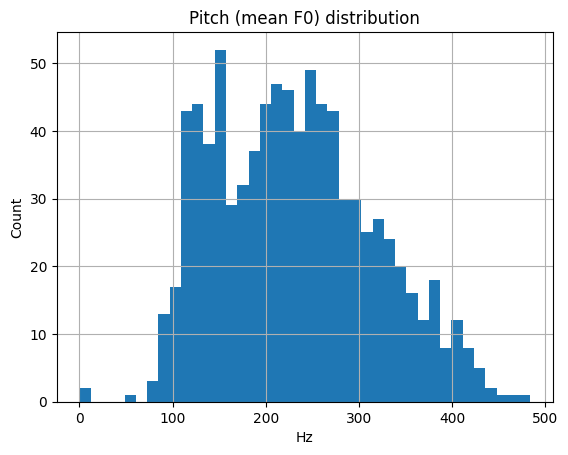

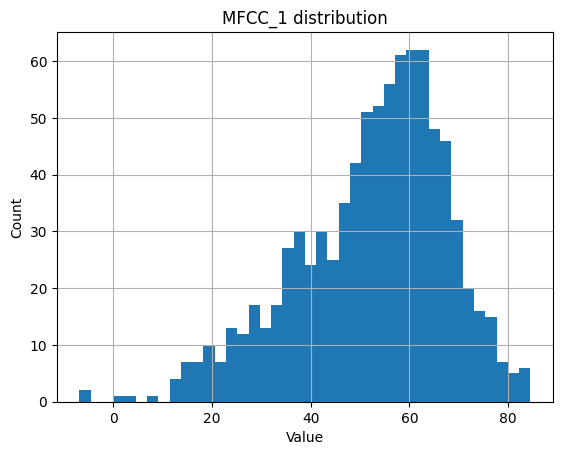

In [8]:

import matplotlib.pyplot as plt

if len(features):
    plt.figure()
    features["pitch_mean"].dropna().hist(bins=40)
    plt.title("Pitch (mean F0) distribution")
    plt.xlabel("Hz"); plt.ylabel("Count")
    plt.show()

    if 'mfcc_1' in features.columns:
        plt.figure()
        features['mfcc_1'].dropna().hist(bins=40)
        plt.title("MFCC_1 distribution")
        plt.xlabel("Value"); plt.ylabel("Count")
        plt.show()
else:
    print("No features to plot yet.")
